In [ ]:
# 1) DETR reposunu klonla
!git clone https://github.com/facebookresearch/detr.git
%cd detr

# 2) Gerekli paketleri yükle
!pip install -r requirements.txt       # DETR’in kendi requirements dosyası
!pip install pycocotools               # COCO araçları

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265 (from 1)
Receiving objects: 100% (265/265), 21.19 MiB | 42.54 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/detr
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-install-zsbi9sb1/pycocotools_f93bb8fff75345ae95775eac3df3820e
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-install-zsbi9sb1/pycocotools_f93bb8fff75345ae95775eac3df3820e
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-zsbi9sb1/panopticapi_e797bc949d364438bd229c056fe07082
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-install-zsbi9sb1/panopticapi_e797bc949d364438bd229c056fe070

# Epoch sonrası evaluate hatası çözümü

In [ ]:
import numpy as np
np.float = float

### Import Testi

In [ ]:
%%bash
python - << 'EOF'
import torch, torchvision
import pycocotools
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("pycocotools OK")
EOF


## Dataset YOLO Kurulumu

In [1]:
!gdown https://drive.google.com/uc?id=1pPaY2P-xrNVwx3PXu9fyncmxFjlrD1uZ

Downloading...
From (original): https://drive.google.com/uc?id=1pPaY2P-xrNVwx3PXu9fyncmxFjlrD1uZ
From (redirected): https://drive.google.com/uc?id=1pPaY2P-xrNVwx3PXu9fyncmxFjlrD1uZ&confirm=t&uuid=587b072b-1063-4f07-b17c-877a0a905a61
To: /content/to_download.tar.gz
100% 2.87G/2.87G [00:50<00:00, 56.7MB/s]


In [ ]:
%%bash
tar -xzf to_download.tar.gz

In [ ]:
# Hücre 2
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# dosyaları bulunduğu yerden doğrudan çalıştır
%run /content/drive/MyDrive/Thermal-Image-Processing/move_extra_to_train.py --processed_dir ./processed --start_idx 70000

Done — moved 0 extra image/label pairs into train starting at 70000


In [ ]:
%run /content/drive/MyDrive/Thermal-Image-Processing/fix_class_in_70ks.py --labels-dir ./processed/train/labels --start-id 70000 --input-class 2 --output-class 0

[ERROR] labels-dir not found: processed/train/labels


In [ ]:
%run /content/drive/MyDrive/Thermal-Image-Processing/split_70ks_to_val_and_test.py --processed_dir ./processed --start_idx 70000 --val_ratio 0.1 --test_ratio 0.1

FileNotFoundError: [Errno 2] No such file or directory: 'processed/train/images'

## YOLO datasetini Dönüşüm için ayarlama

In [ ]:
%%bash
cd /content/detr


# 1) Eski thermal dataset’i sil
rm -rf datasets/thermal

# 2) Klasörleri yeniden oluştur
mkdir -p datasets/thermal/train2017
mkdir -p datasets/thermal/val2017
mkdir -p datasets/thermal/annotations
mkdir -p datasets/thermal/labels/train2017
mkdir -p datasets/thermal/labels/val2017

# 3) processed içindeki görüntüleri kopyala
#    processed/train/images veya processed/images/train gibi
#    kendi yapını kontrol edip bu yolu düzelt
cp -r processed/train/images/*    datasets/thermal/train2017/
cp -r processed/val/images/*      datasets/thermal/val2017/

# 4) processed içindeki label dosyalarını kopyala
#    processed/train/labels veya processed/labels/train gibi
cp -r processed/train/labels/*    datasets/thermal/labels/train2017/
cp -r processed/val/labels/*      datasets/thermal/labels/val2017/

# 5) Hemen kontrol edelim
echo "Train images:" && ls datasets/thermal/train2017 | head -3
echo "Val   images:" && ls datasets/thermal/val2017   | head -3
echo "Train labels:" && ls datasets/thermal/labels/train2017 | head -3
echo "Val   labels:" && ls datasets/thermal/labels/val2017   | head -3

## COCO'ya Dönüştürme

In [ ]:
%%bash
cd /content/detr/

In [ ]:
import os, json
from PIL import Image

# DETR projesinin kökünde çalıştığınızdan emin olun:
os.chdir("/content/detr")

BASE_DIR       = "datasets/thermal"
EXCLUDE_RANGES = [(8000,9999),(12000,13999)]
VALID_EXTS     = {".jpg",".jpeg",".png"}
SPLITS         = ["train","val"]

def in_exclude(fid):
    return any(s<=fid<=e for s,e in EXCLUDE_RANGES)

def yolo_to_bbox(x_c,y_c,bw,bh,w,h):
    xmin=(x_c-bw/2)*w; ymin=(y_c-bh/2)*h
    return [xmin,ymin,bw*w,bh*h]

for split in SPLITS:
    img_dir   = os.path.join(BASE_DIR, f"{split}2017")
    label_dir = os.path.join(BASE_DIR, "labels", f"{split}2017")
    ann_path  = os.path.join(BASE_DIR,"annotations",f"instances_{split}2017.json")

    images, annotations = [], []
    ann_id, val_min = 1, {}

    for fname in sorted(os.listdir(img_dir), key=lambda x:int(x.split(".")[0])):
        if os.path.splitext(fname)[1].lower() not in VALID_EXTS: continue
        fid=int(fname.split(".")[0])
        if split=="train" and in_exclude(fid): continue

        w,h = Image.open(os.path.join(img_dir,fname)).size
        track_id=fid//2000
        is_key=(fid%2000==0)
        if split=="val":
            val_min.setdefault(track_id,fid)
            val_min[track_id]=min(val_min[track_id],fid)

        images.append({
          "id":fid,
          "file_name":fname,          # artık alt klasör eklemiyoruz
          "width":w,"height":h,
          "track_id":track_id,
          "keyframe":is_key
        })

        lab=os.path.join(label_dir,fname.rsplit(".",1)[0]+".txt")
        if not os.path.exists(lab): continue
        for line in open(lab):
            parts=line.strip().split()
            if len(parts)!=5: continue
            cls,x_c,y_c,bw,bh=int(parts[0]),*map(float,parts[1:])
            bbox=yolo_to_bbox(x_c,y_c,bw,bh,w,h)
            annotations.append({
              "id":ann_id,
              "image_id":fid,
              "category_id":cls+1,
              "bbox":[round(x,2) for x in bbox],
              "area":round(bbox[2]*bbox[3],2),
              "iscrowd":0
            })
            ann_id+=1

    if split=="val":
        for img in images:
            if img["id"]==val_min[img["track_id"]]:
                img["keyframe"]=True

    os.makedirs(os.path.dirname(ann_path),exist_ok=True)
    json.dump({"images":images,
               "annotations":annotations,
               "categories":[{"id":1,"name":"person"}]},
              open(ann_path,"w"),indent=2)
    print(f"{split} JSON kaydedildi: {ann_path}")


## COCO Format Kontrolü

In [ ]:
# Hücre: JSON + COCO format validasyonu
import json
from pycocotools.coco import COCO

splits = ["train", "val"]
for split in splits:
    ann_file = f"datasets/thermal/annotations/instances_{split}2017.json"
    print(f"\n== {split.upper()} ==")
    # 1) JSON parse testi
    try:
        with open(ann_file) as f:
            data = json.load(f)
        print("✅ Geçerli JSON")
    except Exception as e:
        print("❌ JSON parse hatası:", e)
        continue

    # 2) COCO schema testi
    try:
        coco = COCO(ann_file)
        n_imgs = len(coco.getImgIds())
        n_anns = len(coco.getAnnIds())
        print(f"✅ COCO olarak yüklendi: {n_imgs} image, {n_anns} annotation")
    except Exception as e:
        print("❌ COCO yükleme hatası:", e)


# DETR Training

In [ ]:
%%bash
cd /content/detr

##### pycocotools Patch (hata çözüm)

In [ ]:
%%bash
# 1) pycocotools cocoeval.py dosyasını bulun ve patch’le
PYCOCO=$(python3 - << 'EOF'
import pycocotools.cocoeval as c; print(c.__file__)
EOF
)
echo "Patching $PYCOCO …"
sed -i "s/np\.float/float/g" "$PYCOCO"

# 2) DETR cache’lerini temizle
rm -rf /content/detr/__pycache__ /content/detr/datasets/__pycache__

*Not: output_dir locali gösteriyor*

##### 0'dan eğitim

In [ ]:
!python3 main.py \
  --backbone resnet18 \
  --dataset_file coco \
  --coco_path datasets/thermal \
  --output_dir ../outputs/thermal_r18 \
  --device cuda \
  --batch_size 12 \
  --num_workers 8 \
  --epochs 50 \
  --lr 1e-4 \
  --lr_backbone 1e-5 \
  --weight_decay 1e-4 \
  --lr_drop 20

## DETR patchleri
#### *main.py*
* --print_freq argümanı
* --fp16 (mixed-precision) desteği eklendi: GradScaler ile yarı-hassas (float16) eğitim yapabiliyoruz, bu da GPU belleğinden tasarruf sağlar ve bazen hız kazandırır.
* resume yükleme esnasında load_state_dict(..., strict=False) kullanarak küçük yapısal uyuşmazlıkları es geçebilmek (örneğin backbone değişikliği vs.) ve kaldığımız yerden devam edebilmek.
* train_one_epoch’e print_freq ve scaler (fp16) parametreleri geçiriliyor.
#### *engine.py*
* train_one_epoch imzası güncellendi: artık print_freq ve scaler argümanlarını alıyor.
* Döngü içinde torch.cuda.amp.autocast() ve scaler.scale()/scaler.step()/scaler.update() kullanılarak mixed-precision eğitim entegre edildi.
* metric_logger.log_every(...) çağrısına print_freq geçilerek log sıklığı kontrol altına alındı.

In [ ]:
!cp /content/drive/MyDrive/Thermal-Image-Processing/DETR_patched_files/main.py /content/drive/MyDrive/Thermal-Image-Processing/DETR_patched_files/engine.py /content/detr

# Resume Eğitim

In [ ]:
!python3 main.py \
  --backbone resnet18 \
  --dataset_file coco \
  --coco_path datasets/thermal \
  --output_dir /content/drive/MyDrive/Thermal-Image-Processing/outputs/thermal_r18_epoch_to_400_resume/ \
  --device cuda \
  --batch_size 24 \
  --num_workers 12 \
  --epochs 400 \
  --lr 5e-5 \
  --lr_backbone 5e-6 \
  --weight_decay 1e-4 \
  --print_freq 100 \
  --resume /content/drive/MyDrive/Thermal-Image-Processing/outputs/thermal_r18_epoch_to_300_resume/checkpoint0299.pth \
  --fp16

##*NOT: Torch.load hatası main.py içi checkpoint = ... satırı ile düzeltildi (weights_only=False argümanı eklendi torch.load'a)*

### BBOX kontrol

In [ ]:
import json
from pathlib import Path
import numpy as np

for split in ("train","val"):
    fn = Path("datasets/thermal/annotations")/f"instances_{split}2017.json"
    data = json.load(open(fn))
    bad = []
    for ann in data["annotations"]:
        x,y,w,h = ann["bbox"]
        if w <= 0 or h <= 0:
            bad.append(("zero_area", ann["id"], x,y,w,h))
    print(split, "zero-area anns:", len(bad))


#### JSON uyumsuzluk kontrol

In [ ]:
from datasets import build_dataset
import argparse

# Minimal args stub
class A: pass
args = A()
args.dataset_file        = 'coco'
args.coco_path           = 'datasets/thermal'
args.coco_panoptic_path  = None
args.remove_difficult    = False
args.masks               = False
args.num_workers         = 2    # doesn’t really matter here
# the rest of args aren’t used by build_dataset

ds_train = build_dataset(image_set='train', args=args)
ds_val   = build_dataset(image_set='val',   args=args)
print("Train dataset length:", len(ds_train))
print("Val   dataset length:",   len(ds_val))


#### Id'ler unique olmalı

In [ ]:
import json
from collections import Counter

def check_ids(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Images içindeki id'ler
    img_ids = [img['id'] for img in data.get('images', [])]
    dup_img = [i for i, c in Counter(img_ids).items() if c > 1]

    # Annotations içindeki id'ler ve image_id'ler
    ann_ids = [ann['id'] for ann in data.get('annotations', [])]
    dup_ann = [i for i, c in Counter(ann_ids).items() if c > 1]

    imgref = [ann['image_id'] for ann in data.get('annotations', [])]
    dup_imgref = [i for i, c in Counter(imgref).items() if c > 1]

    print(f"== {json_path} ==")
    if dup_img:
        print(f"⚠️ Duplicate image IDs: {dup_img}")
    else:
        print("✅ All image IDs are unique")

    if dup_ann:
        print(f"⚠️ Duplicate annotation IDs: {dup_ann}")
    else:
        print("✅ All annotation IDs are unique")

    # image_id tekrarını görmek genelde normaldir (birden fazla annotation aynı image_id'yi refer eder),
    # ama burayı da istersen kontrol etmiş olursun:
    if dup_imgref:
        print(f"🔍 image_id reuse count for annotations (normal): {len(dup_imgref)} unique images repeated")
    else:
        print("🚀 No annotations found or every annotation references a distinct image_id (sürpriz!)")

# Örnek kullanım:
for split in ("train", "val"):
    fn = f"datasets/thermal/annotations/instances_{split}2017.json"
    check_ids(fn)


In [ ]:
!python3 -m json.tool datasets/thermal/annotations/instances_train2017.json > /dev/null

##### Exclude range'ler problem yaratıyor mu?

In [ ]:
from pathlib import Path

EXCLUDE = set(range(8000,10000)) | set(range(12000,14000))
train_ids = {int(Path(p).stem) for p in Path("datasets/thermal/train2017").iterdir() if p.suffix in (".jpg",".png")}
val_ids   = {int(Path(p).stem) for p in Path("datasets/thermal/val2017").iterdir()   if p.suffix in (".jpg",".png")}

print("Excluded IDs ∩ train:", train_ids & EXCLUDE)
print("Excluded IDs ∩  val:",   val_ids   & EXCLUDE)


# GRAF ÇİZDİRME

⚠️  missing /content/drive/MyDrive/Thermal-Image-Processing/outputs/thermal_r18_epoch100_resume/log.txt
⚠️  missing /content/drive/MyDrive/Thermal-Image-Processing/outputs/thermal_r18_epoch150_resume/log.txt
⚠️  missing /content/drive/MyDrive/Thermal-Image-Processing/outputs/thermal_r18_epoch175_resume/log.txt
Epoch aralığı: 0 → 332


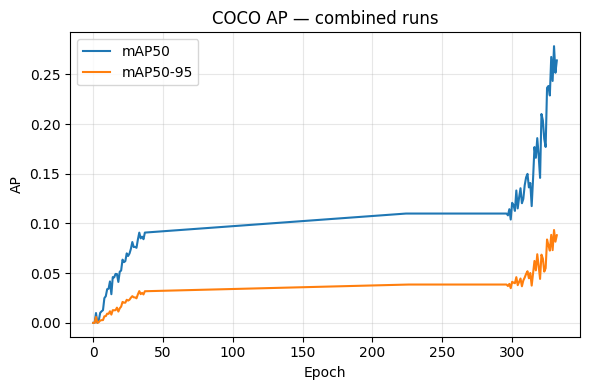

In [ ]:
import pandas as pd, json, ast, matplotlib.pyplot as plt, pathlib, re

# --- ayarlar ---
ROOT = pathlib.Path("/content/drive/MyDrive/Thermal-Image-Processing/outputs")
PAT  = re.compile(r"^thermal_r18")           # hangi klasörler?
EXCLUDE = {"thermal_r18_epoch_to_350_resume", "thermal_r18_resume","thermal_r18_epoch_334_resume"}

# -------- logları topla ----------
frames = []
for run_dir in ROOT.iterdir():
    if not run_dir.is_dir() or run_dir.name in EXCLUDE:      continue
    if not PAT.match(run_dir.name):                         continue
    log_f = run_dir/"log.txt"
    if not log_f.exists():
        print(f"⚠️  missing {log_f}")
        continue
    df = pd.read_json(log_f, lines=True)
    df["run"] = run_dir.name
    frames.append(df)

if not frames:
    raise RuntimeError("Hiç log bulunamadı!")

df_all = pd.concat(frames, ignore_index=True)

# aynı epoch birden çok kez varsa, _son_ kaydı tut
df_all = (df_all
          .sort_values(["epoch","run"])        # run isimleri kronolojikse yeterli
          .drop_duplicates("epoch", keep="last")
          .sort_values("epoch")
          .reset_index(drop=True))

# COCO eval listesini aç
def get_ap(row, idx):          # idx: 1 -> AP50, 0 -> AP50:95
    try:
        lst = row["test_coco_eval_bbox"]
        if isinstance(lst, str):
            lst = ast.literal_eval(lst)
        return lst[idx]
    except Exception:
        return None

df_all["mAP50"]     = df_all.apply(get_ap, axis=1, args=(1,))
df_all["mAP50_95"]  = df_all.apply(get_ap, axis=1, args=(0,))

print("Epoch aralığı:", df_all["epoch"].min(), "→", df_all["epoch"].max())

# ------------- çiz -------------
plt.figure(figsize=(6,4))
plt.plot(df_all["epoch"], df_all["mAP50"],     label="mAP50")
plt.plot(df_all["epoch"], df_all["mAP50_95"],  label="mAP50-95")
plt.xlabel("Epoch"); plt.ylabel("AP"); plt.title("COCO AP — combined runs")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout()
plt.show()
